In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import resample_poly, iirnotch, filtfilt, welch
import os
import random

fs_old = 1000
fs_new = 200
bin_sec = 2
bin_len = fs_new * bin_sec

In [ ]:
import scipy.io as sio

mat = sio.loadmat("George_ECoG/Session1/ECoG_ch1.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'ECoGData_ch1'])


In [5]:
def load_session(folder):
    signals = []
    for ch in range(1, 129):
        mat = sio.loadmat(os.path.join(folder, f"ECoG_ch{ch}.mat"))
        keys = [k for k in mat.keys() if not k.startswith('__')]
        sig = mat[keys[0]].squeeze()
        signals.append(sig)
    return np.vstack(signals)  # (128, T)

In [6]:
def preprocess(data):
    # downsampling
    data_ds = resample_poly(data, up=1, down=5, axis=1).astype(np.float32)
    #average re-reference (demeaning across electrodes)
    data_mean = data_ds - np.mean(data_ds, axis=0, keepdims=True)
    # 50 Hz notch filter
    fs = 200
    f0 = 50
    Q = 30
    # recursive filter (infinite impluse response)
    b, a = iirnotch(f0, Q, fs) 
    data_filt = filtfilt(b, a, data_mean, axis=1) # filtfilt is used for zero-phase digital filtering...

    return data_ds, data_mean, data_filt



# Now we are calculating non-overlapping bins of length 2 secs

In [7]:
def make_bins(data, fs=200, bin_sec=2):
    bin_len = fs * bin_sec
    total_samples = data.shape[1]

    n_bins = total_samples // bin_len
    print(f"total_samples= {total_samples}")
    print(f"bins = {n_bins}")
    bins = []

    
    for i in range(n_bins):
        start = i * bin_len
        end = start + bin_len
        bins.append(data[:, start:end])
    return bins



In [8]:
def pick_random_bins(bins, n=20):
    return random.sample(bins, n)

In [9]:
session_folders = ["George_ECoG/Session1", "George_ECoG/Session2", "George_ECoG/Session3"]

all_selected_bins = []

for folder in session_folders:
    raw = load_session(folder)
    data_ds, data_ref, data_filt = preprocess(raw)
    bins = make_bins(data_filt)
    selected = pick_random_bins(bins, 20)
    all_selected_bins.extend(selected)

print("Total bins selected:", len(all_selected_bins))

total_samples= 677041
bins = 1692
total_samples= 612337
bins = 1530
total_samples= 393187
bins = 982
Total bins selected: 60


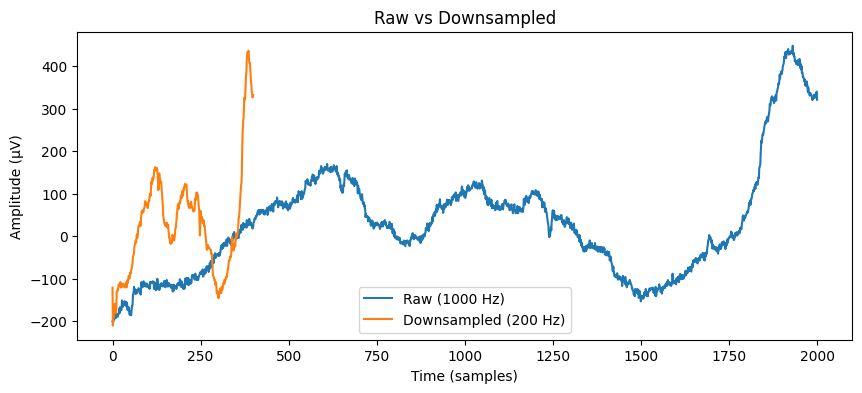

In [10]:
ch = 10
plt.figure(figsize=(10,4))
plt.plot(raw[ch, :2000], label="Raw (1000 Hz)")
plt.plot(data_ds[ch, :400], label="Downsampled (200 Hz)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.title("Raw vs Downsampled")
plt.show()


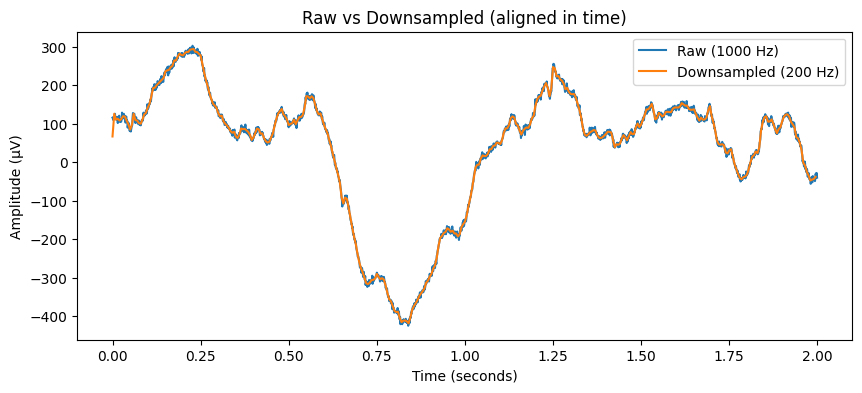

In [ ]:
# plotting against the time (interpolated signal)

fs_old = 1000
fs_new = 200

raw_seg = raw[ch, :2000]
new_seg = data_ds[ch, :400]

t_raw = np.arange(len(raw_seg)) / fs_old
t_new = np.arange(len(new_seg)) / fs_new

plt.figure(figsize=(10,4))
plt.plot(t_raw, raw_seg, label="Raw (1000 Hz)")
plt.plot(t_new, new_seg, label="Downsampled (200 Hz)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (µV)")
plt.title("Raw vs Downsampled (aligned in time)")
plt.legend()
plt.show()

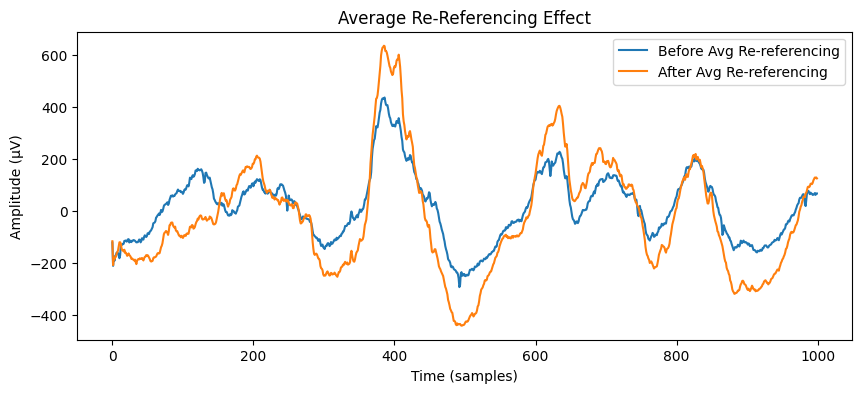

In [12]:
plt.figure(figsize=(10,4))
plt.plot(data_ds[ch, :1000], label="Before Avg Re-referencing")
plt.plot(data_ref[ch, :1000], label="After Avg Re-referencing")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.title("Average Re-Referencing Effect")
plt.show()


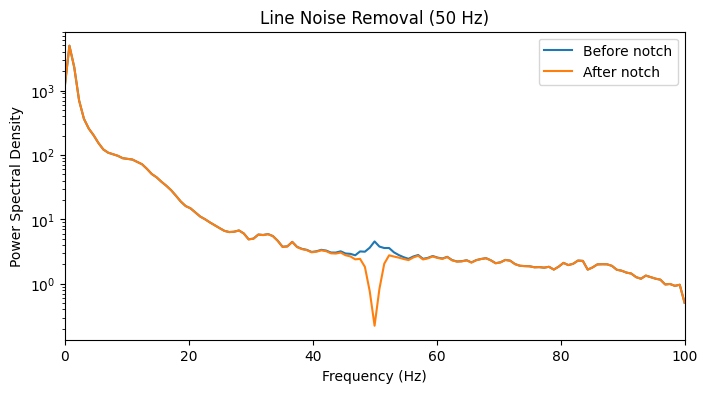

In [13]:
f1, P1 = welch(data_ref[ch], fs=200)
f2, P2 = welch(data_filt[ch], fs=200)

plt.figure(figsize=(8,4))
plt.semilogy(f1, P1, label="Before notch")
plt.semilogy(f2, P2, label="After notch")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.xlim(0,100)
plt.legend()
plt.title("Line Noise Removal (50 Hz)")
plt.show()



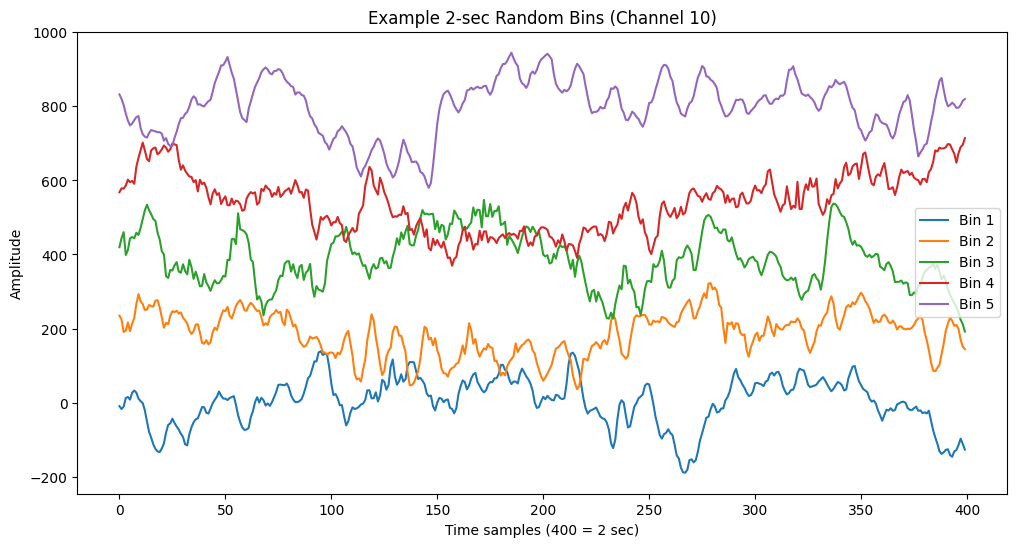

In [14]:
plt.figure(figsize=(12,6))

for i in range(5):
    plt.plot(all_selected_bins[i][10] + i*200, label=f"Bin {i+1}")

plt.title("Example 2-sec Random Bins (Channel 10)")
plt.xlabel("Time samples (400 = 2 sec)")
plt.legend()
plt.ylabel("Amplitude")
plt.show()


In [15]:
print("Session-wise bins selected:")
print("Session-1:", 20)
print("Session-2:", 20)
print("Session-3:", 20)
print("Total:", len(all_selected_bins))


Session-wise bins selected:
Session-1: 20
Session-2: 20
Session-3: 20
Total: 60


# Now, adding the bipolar persepective where we have to select ECog channel pairs such that each electrode and electrode pair is used ONLY ONCE...

In [16]:
def bipolar_reference_unique(data):
    # data shape: (128, T)
    bipolar_signals = []
    pairs = []

    # using ch1-ch2, ch3-ch4, ch5-ch6... scheme
    for ch in range(0, data.shape[0], 2): #(start, end, step)
        sig = data[ch] - data[ch+1]
        bipolar_signals.append(sig)
        pairs.append((ch+1, ch+2))

    bipolar_data = np.vstack(bipolar_signals)  # shape (64, T)
    return bipolar_data, pairs

bipolar_data, pairs = bipolar_reference_unique(data_filt)

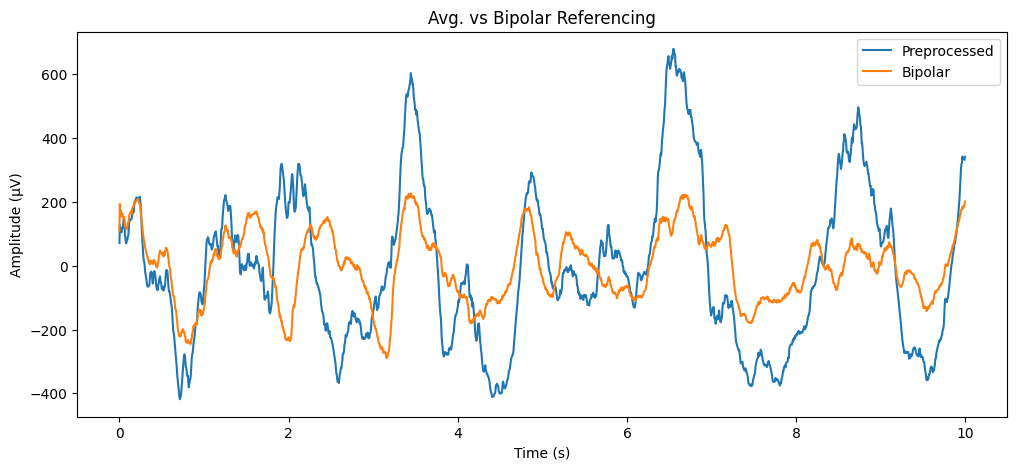

In [17]:
ch = 0 
t = np.arange(2000) / 200  # small window

plt.figure(figsize=(12,5))
plt.plot(t, data_filt[ch, :2000], label="Preprocessed")
plt.plot(t, bipolar_data[ch, :2000], label="Bipolar")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("Avg. vs Bipolar Referencing")
plt.show()


/var/folders/4_/jc92k74542q9d_vfxt2j3d240000gp/T/ipykernel_1508/3228425164.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


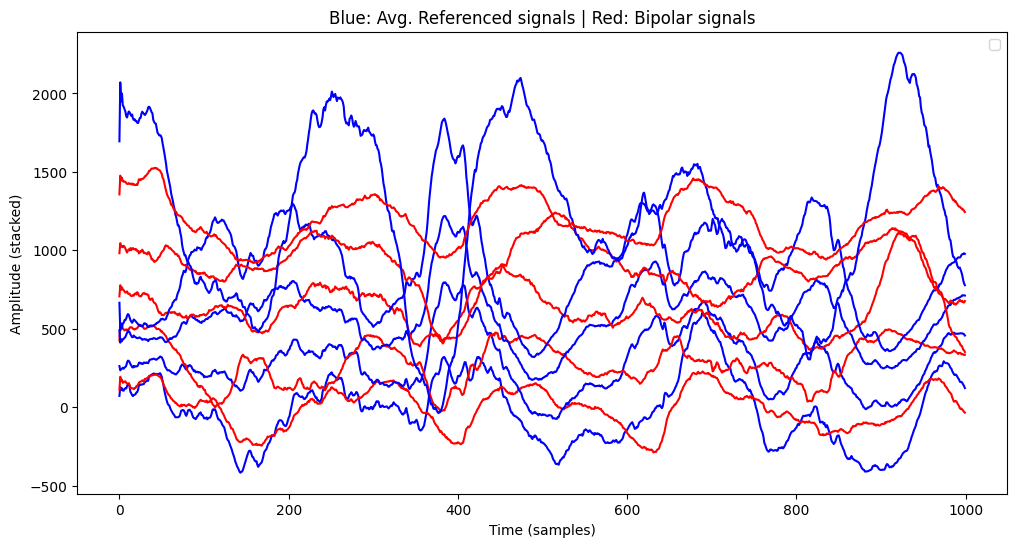

In [18]:
plt.figure(figsize=(12,6))

for i in range(5):
    plt.plot(data_filt[i, :1000] + i*300, color='blue')
    plt.plot(bipolar_data[i, :1000] + i*300, color='red')

plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (stacked)")
plt.title("Blue: Avg. Referenced signals | Red: Bipolar signals")
plt.legend()
plt.show()


In [19]:
print(len(bins))

982


In [20]:
# computing grnd_avg time series per bin
grnd_avg_bins = []
for bin_data in bins:
    grnd_avg_bins.append(np.mean(bin_data, axis=0))

In [21]:
grnd_avg = np.concatenate(grnd_avg_bins)
sigma_g = np.std(grnd_avg)
threshold = 4 * sigma_g

In [22]:
# detecting bad bins
bad_bins_idx = set()

for i, g_bin in enumerate(grnd_avg_bins):
    if np.max(np.abs(g_bin))>threshold:
        bad_bins_idx.update([i-1,i,i+1])

# keeping valid indices only
bad_bins_idx = {i for i in bad_bins_idx if 0 <= i < len(bins)}

In [23]:
# creating clean bin list
clean_bins = []
for i in range(len(bins)):
    if i not in bad_bins_idx:
        clean_bins.append(bins[i])

print(len(clean_bins))

568


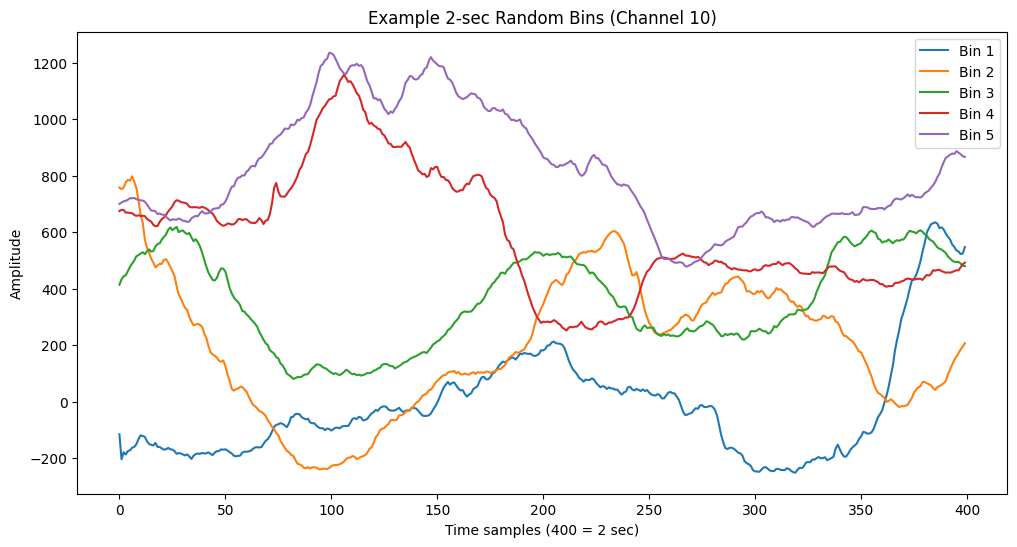

In [24]:
plt.figure(figsize=(12,6))

for i in range(5):
    plt.plot(clean_bins[i][10] + i*200, label=f"Bin {i+1}")

plt.title("Example 2-sec Random Bins (Channel 10)")
plt.xlabel("Time samples (400 = 2 sec)")
plt.legend()
plt.ylabel("Amplitude")
plt.show()